In [99]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from itertools import chain
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('C:/Users/User/Desktop/Python/Feature Engineering/Лекция 4. Feature Selection/дз/дз/data/aac_shelter_outcomes.csv')
data.head(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


***Проверка наличия/обработка пропусков***

In [3]:
data.isnull().sum() #Прорим количество значений NaN в каждом признаке

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

Видим, что в нашем датафрейме в 5 столбцов ('age_upon_outcome', 'name', 'outcome_subtype', 'outcome_type' и 'sex_upon_outcome') в которых есть отсутсвующие значения (NaN)

In [4]:
data.shape #для себя смотрю общую размерность датафрейма

(78256, 12)

Предлагаю удалить строки со значением NaN в талбцах 'age_upon_outcome', 'outcome_type' и 'sex_upon_outcome'. Т.к. удалится максимум 22 строки (0,03% от общего количества), что несущественно для нашего датафрейма.

In [5]:
data.dropna(subset=['age_upon_outcome','outcome_type','sex_upon_outcome'], inplace=True)

Столбцы 'name' и 'outcome_subtype' предлагаю сразу удалить, т.к. кличка животного никакой значимой роли при обучении модели не будет играть. А в столбце outcome_subtype отсутвующих значений больше половины и его значения тоже маловероятно, что понядобятся для обученя модели, поэтому его тоже удалим.

In [6]:
data = data.dropna(axis=1)

In [7]:
data.isnull().sum()

age_upon_outcome    0
animal_id           0
animal_type         0
breed               0
color               0
date_of_birth       0
datetime            0
monthyear           0
outcome_type        0
sex_upon_outcome    0
dtype: int64

Теперь у нас нет отсутсвующих значений в датафрейме.

***Удаление лишних признаков***

 На мой взгляд лишними признаками на текущем этапе в датафрейме являются Id животного (animal_id) и monthyear, т.к. он дублирует признак datetime. Удалим эти 2 признака.

In [8]:
data.drop(['animal_id', 'monthyear'], axis='columns', inplace=True)

***Создадим свои признаки***

В датафрейме сразу выделяется признак возврат животного (age_upon_outcome), который можно привести в числовой вид. А именно перевести возвраст в количество дней. Создам признак возвраст в днях.

In [9]:
def age_days(age_upon_outcome):
    try:
        age = age_upon_outcome.split(" ")
    except AttributeError:
        return 0
    quantity = 0
    if age[1] == 'day' or age[1] == 'days':
         quantity = 1
    elif age[1] == 'weeks' or age[1] == 'week':
         quantity = 7
    elif age[1] == 'months' or age[1] == 'month':
        quantity = 30
    elif age[1] == 'years' or age[1] == 'year':
        quantity = 365
    return int(age[0]) * quantity

data['age_days'] = data['age_upon_outcome'].apply(age_days)

Так же можно создать признак пола животного, на основании данных имеющихся в признаке sex_upon_outcome.

In [10]:
def gender(sex_upon_outcome):
    if sex_upon_outcome == 'Unknown':
        return('Unknown')
    else:
        type = sex_upon_outcome.split(" ")
        if type[1] == "Female":
            sex = "Female"
        else:
            sex = "Male"
        return (sex)
    

data['sex'] = data['sex_upon_outcome'].apply(gender)

По аналогии из признака sex_upon_outcome создадим новый признак, показывающий кастировано/стерилизовано животное или неопределено.

In [11]:
def reproduction (sex_upon_outcome):
    if sex_upon_outcome == 'Unknown':
        return('Unknown')
    else:
        type = sex_upon_outcome.split(" ")
        if type[0] == "Spayed" or type[0] == "Neutered":
            reproductive = "Neutered"
        else:
            reproductive = "Intact"
        return (reproductive)
               
data['reproductive'] = data['sex_upon_outcome'].apply(reproduction)

Теперь можно удалить признаки 'age_upon_outcome' и 'sex_upon_outcome', т.к. мы из них вытащили всю полезную информацию и они нам больше не нужны.

In [12]:
data.drop(['age_upon_outcome', 'sex_upon_outcome'], axis='columns', inplace=True)

In [62]:
data.datetime = pd.to_datetime(data.datetime) #сконвертируем данные по датам в дату
data.date_of_birth = pd.to_datetime(data.date_of_birth)

In [63]:
data.head(5)

,animal_type,breed,color,date_of_birth,datetime,outcome_type,age_days,sex,reproductive
0,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,Transfer,14,Male,Intact
1,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Transfer,365,Female,Neutered
2,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,Adoption,365,Male,Neutered
3,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Transfer,3285,Male,Neutered
4,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,Euthanasia,150,Unknown,Unknown


***Посмотрим распределине результата приёма (outcome_type) в разрезе животных***

animal_type,Bird,Cat,Dog,Livestock,Other
outcome_type,,,,,
Adoption,0.342342,0.432796,0.453316,0.222222,0.049965
Died,0.012012,0.013699,0.003120,0.000000,0.031817
Disposal,0.066066,0.000544,0.000384,0.000000,0.059392
Euthanasia,0.255255,0.049358,0.033956,0.000000,0.715767
Missing,0.003003,0.000952,0.000384,0.000000,0.000000
Relocate,0.021021,0.000000,0.000000,0.000000,0.002121
Return to Owner,0.027027,0.048644,0.291043,0.111111,0.008956
Rto-Adopt,0.000000,0.001122,0.002645,0.000000,0.000000
Transfer,0.273273,0.452886,0.215151,0.666667,0.131982


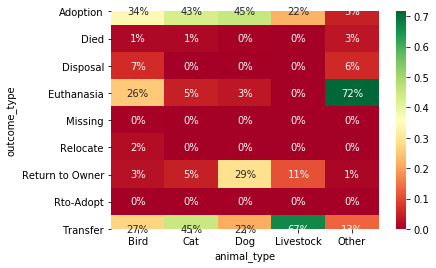

In [14]:
outcome_by_type = data.pivot_table(columns='animal_type', index='outcome_type', values='age_days', aggfunc='count', fill_value=0)              
percentage_ratio = outcome_by_type.apply(lambda x: x / sum(x), axis=0)
sns.heatmap(data=percentage_ratio, annot=True, cmap='RdYlGn', fmt="2.0%")
percentage_ratio

И посмотрим распределение результата приёма в разрезе возраста животного.

outcome_type,Adoption,Died,Disposal,Euthanasia,Missing,Relocate,Return to Owner,Rto-Adopt,Transfer
age_days,,,,,,,,,
0,0.031915,0.042553,0.000000,0.095745,0.000000,0.000000,0.010638,0.000000,0.819149
1,0.000000,0.071895,0.006536,0.052288,0.000000,0.000000,0.045752,0.000000,0.823529
2,0.000000,0.050691,0.000000,0.027650,0.000000,0.000000,0.000000,0.000000,0.921659
3,0.004255,0.021277,0.000000,0.055319,0.000000,0.000000,0.000000,0.000000,0.919149
4,0.000000,0.080882,0.000000,0.029412,0.000000,0.000000,0.014706,0.000000,0.875000
5,0.017241,0.112069,0.000000,0.103448,0.000000,0.000000,0.000000,0.000000,0.767241
6,0.000000,0.039474,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.907895
7,0.001064,0.031915,0.001064,0.043617,0.000000,0.000000,0.008511,0.000000,0.913830
14,0.000752,0.015789,0.000752,0.039098,0.000752,0.000000,0.021053,0.000000,0.921805


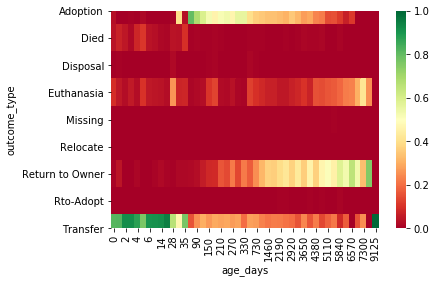

In [15]:
outcome_by_age = data.pivot_table(columns="outcome_type", index="age_days", values="animal_type",aggfunc="count",fill_value=0)
percentage_ratio = outcome_by_age.apply(lambda x: x / sum(x), axis=1)
sns.heatmap(data=percentage_ratio.T, cmap='RdYlGn')
percentage_ratio

In [65]:
data.head()

,animal_type,breed,color,date_of_birth,datetime,outcome_type,age_days,sex,reproductive
0,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,Transfer,14,Male,Intact
1,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Transfer,365,Female,Neutered
2,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,Adoption,365,Male,Neutered
3,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Transfer,3285,Male,Neutered
4,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,Euthanasia,150,Unknown,Unknown


In [66]:
x, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x, y)
print(clf.feature_importances_)
print(clf.predict([[0, 0, 0, 0]]))

[0.14205973 0.76664038 0.0282433  0.06305659]
[1]


Уделим внимание признакам цвета и породы! Добавим новые признаки

In [67]:
unique_colors = data.color.unique()
colors = [color.split("/") for color in unique_colors]
single = set(chain.from_iterable([i.split(" ") for i in chain.from_iterable(colors)]))

In [68]:
unique_breeds = data.breed.unique() 
unique_breeds_mix = [br.replace(" Mix", "") for br in unique_breeds]
breeds = set(chain.from_iterable([breed.split("/") for breed in unique_breeds_mix]))

In [69]:
single_breed = set(chain.from_iterable([i.split(" ") for i in chain.from_iterable(breeds)]))

In [70]:
data2 = data.copy(deep=True)
for color_el in list(single):
    data2["c_" + color_el] = data2['color'].str.contains(color_el, regex=False).astype(int)
    
data2["breed_Mix"] = data2['breed'].str.contains(" Mix", regex=False).astype(int)
data2

,animal_type,breed,color,date_of_birth,datetime,outcome_type,age_days,sex,reproductive,c_Torbie,...,c_Blue,c_Silver,c_Apricot,c_Buff,c_Green,c_Lynx,c_Orange,c_Tabby,c_Point,breed_Mix
0,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,Transfer,14,Male,Intact,0,...,0,0,0,0,0,0,1,1,0,1
1,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Transfer,365,Female,Neutered,0,...,0,0,0,0,0,0,0,0,0,1
2,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,Adoption,365,Male,Neutered,0,...,1,0,0,0,0,0,0,0,0,0
3,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Transfer,3285,Male,Neutered,0,...,0,0,0,0,0,0,0,0,0,1
4,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,Euthanasia,150,Unknown,Unknown,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78250,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04,2018-02-01 18:40:00,Adoption,30,Male,Neutered,0,...,0,0,0,0,0,0,0,0,0,0
78251,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04,2018-02-01 18:26:00,Adoption,30,Female,Neutered,0,...,0,0,0,0,0,0,0,0,0,0
78252,Dog,Mastiff Mix,Blue/White,2014-12-30,2018-02-01 18:06:00,Adoption,1095,Male,Neutered,0,...,1,0,0,0,0,0,0,0,0,1
78254,Dog,Standard Schnauzer,Red,2017-11-13,2018-02-01 18:32:00,Adoption,60,Female,Neutered,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
data3 = pd.get_dummies(data2, columns=['animal_type', 'reproductive', 'sex']).drop(['breed', 'color'], axis=1)

In [72]:
columns_to_observe = (['date_of_birth','datetime','age_days','breed_Mix','animal_type_Bird','animal_type_Cat','animal_type_Dog','animal_type_Livestock','animal_type_Other','reproductive_Intact','reproductive_Neutered','reproductive_Unknown','sex_Female','sex_Male','sex_Unknown'])

In [77]:
minMax = MinMaxScaler()
data3[['date_of_birth', 'datetime']] = minMax.fit_transform(data3[['date_of_birth', 'datetime']])

Ипользуем метод главных компонент

In [79]:
train_columns = columns_to_observe
pca_components = 5
pca = PCA(n_components=pca_components, whiten=False)
pca_names = ["v" + str(n) for n in range(1,pca_components+1)]
df = data3[train_columns]
x = df
df.head()

,date_of_birth,datetime,age_days,breed_Mix,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,reproductive_Intact,reproductive_Neutered,reproductive_Unknown,sex_Female,sex_Male,sex_Unknown
0,0.866786,0.185733,14,1,0,1,0,0,0,1,0,0,0,1,0
1,0.802860,0.023413,365,1,0,0,1,0,0,0,1,0,1,0,0
2,0.818105,0.154761,365,0,0,0,1,0,0,0,1,0,0,1,0
3,0.517506,0.162374,3285,1,0,0,1,0,0,0,1,0,0,1,0
4,0.847755,0.176213,150,1,0,0,0,0,1,0,0,1,0,0,1


In [91]:
labelEncoder = LabelEncoder()
y = data3["outcome_type"]
y_other = y.to_frame()

In [92]:
scaler = StandardScaler().fit(x)
x_scaled= pd.DataFrame(scaler.transform(x), columns = x.columns, index = x.index)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_other, test_size=0.25, random_state=42)
print (x_train.shape, y_train.shape)

(58677, 15) (58677, 1)


In [93]:
x_train.head()

,date_of_birth,datetime,age_days,breed_Mix,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,reproductive_Intact,reproductive_Neutered,reproductive_Unknown,sex_Female,sex_Male,sex_Unknown
49067,-0.208210,1.367912,0.645172,-2.306543,-0.06538,-0.776269,0.876760,-0.010726,-0.239463,-0.560103,0.690353,-0.302752,-0.884515,1.046922,-0.302752
45716,1.004218,0.831382,-0.716046,0.433549,-0.06538,1.288214,-1.140564,-0.010726,-0.239463,1.785386,-1.448534,-0.302752,1.130563,-0.955181,-0.302752
21025,-3.404767,-0.890259,3.407338,0.433549,-0.06538,-0.776269,0.876760,-0.010726,-0.239463,-0.560103,0.690353,-0.302752,1.130563,-0.955181,-0.302752
1738,-0.555476,-1.544346,-0.045369,0.433549,-0.06538,1.288214,-1.140564,-0.010726,-0.239463,-0.560103,0.690353,-0.302752,-0.884515,1.046922,-0.302752
17286,0.096183,-1.411378,-0.679154,0.433549,-0.06538,-0.776269,0.876760,-0.010726,-0.239463,-0.560103,0.690353,-0.302752,-0.884515,1.046922,-0.302752


In [94]:
y_train.head()

,outcome_type
49067,Adoption
45716,Transfer
21025,Transfer
1738,Transfer
17286,Adoption


***Создадим модель деревья решений. И обучим модель***

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


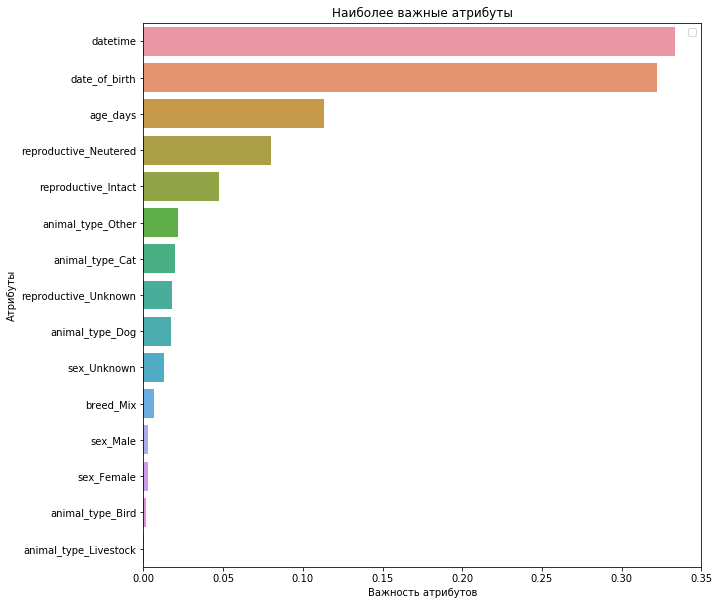

In [96]:
model=RandomForestClassifier(n_estimators=100)

model.fit(x_train,y_train)
headers = list(x_train.columns.values)
feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [100]:
model_pred = model.predict(x_test)
print(classification_report(y_test, model_pred))
model.score(x_test, y_test)

                 precision    recall  f1-score   support

       Adoption       0.70      0.76      0.73      8248
           Died       0.20      0.09      0.13       179
       Disposal       0.41      0.38      0.39        74
     Euthanasia       0.62      0.53      0.57      1531
        Missing       0.00      0.00      0.00        10
       Relocate       0.00      0.00      0.00         2
Return to Owner       0.44      0.44      0.44      3512
      Rto-Adopt       0.00      0.00      0.00        30
       Transfer       0.65      0.63      0.64      5974

       accuracy                           0.63     19560
      macro avg       0.34      0.31      0.32     19560
   weighted avg       0.63      0.63      0.63     19560



0.6322085889570552